### Code to remove blurring and getting defined edges

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

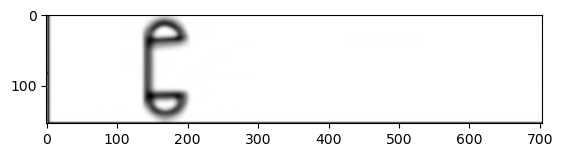

In [4]:
image_path = "circ_cab_upscaled.jpeg"

# Load the image
img = cv2.imread(image_path)
plt.imshow(img)

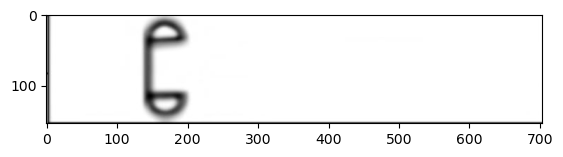

In [12]:
# Grayscale Image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = cv2.bilateralFilter(gray, 3, 5, 3)
# 30,63,10
plt.imshow(gray, cmap='gray')

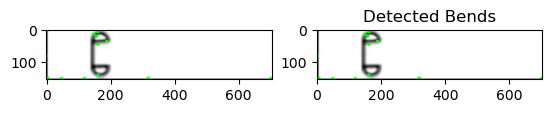

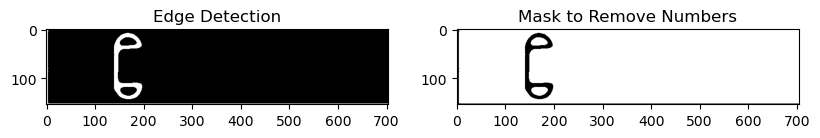

In [104]:
# Apply Laplacian edge detection
lap = cv2.Laplacian(gray, cv2.CV_64F)
lap = np.uint8(np.absolute(lap))

# Contour detection
contours, hierarchy = cv2.findContours(lap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Remove small objects by calculating the perimeter
perimeter_threshold = 60  # Adjust this threshold as needed
filtered_contours = [cnt for cnt in contours if cv2.arcLength(cnt, True) > perimeter_threshold]

# Draw contours on a white background
white_background = np.ones_like(img) * 255
contour_image = cv2.drawContours(white_background, filtered_contours, -1, (0, 0, 0), 2)

# Threshold
threshold_value = 120
_, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)

# Remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Invert the mask to create a mask for numbers
mask = cv2.bitwise_not(thresh)

def find_arcs(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using Canny
    edges = cv2.Canny(blurred, 80, 100)

    # Find contours in the edge map
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    def detect_bends(contour, angle_threshold=5, distance_threshold=115):
        bends = 0
        significant_points = []

        for i in range(2, len(contour) - 2):
            prev_point = contour[i - 2][0]
            current_point = contour[i][0]
            next_point = contour[i + 2][0]

            # Calculate vectors
            vector1 = np.array([current_point[0] - prev_point[0], current_point[1] - prev_point[1]])
            vector2 = np.array([next_point[0] - current_point[0], next_point[1] - current_point[1]])

            # Normalize vectors
            norm1 = np.linalg.norm(vector1)
            norm2 = np.linalg.norm(vector2)
            if norm1 == 0 or norm2 == 0:
                continue

            vector1 = vector1 / norm1
            vector2 = vector2 / norm2

            # Calculate dot product and angle
            dot_product = np.dot(vector1, vector2)
            angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

            # Check if the angle indicates a significant bend
            if angle < angle_threshold:
                significant_points.append(current_point)

        # Group significant points that are close to each other
        if significant_points:
            grouped_points = [significant_points[0]]
            for pt in significant_points[1:]:
                if np.linalg.norm(np.array(pt) - np.array(grouped_points[-1])) > distance_threshold:
                    grouped_points.append(pt)

            bends = len(grouped_points)
            for pt in grouped_points:
                cv2.circle(image, tuple(pt), 5, (0, 255, 0), -1)

        return bends

    total_bends = 0
    for contour in contours:
        total_bends += detect_bends(contour)

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('')

    plt.subplot(1, 2, 2)
    plt.title('Detected Bends')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

find_arcs('circ_cab_upscaled.jpeg')

# Plotting the results
plt.figure(figsize=(15, 4))

# Plot the edge detection result
plt.subplot(1, 3, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Edge Detection')

# Plot the mask used to remove numbers
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Mask to Remove Numbers')

# Show the plots
plt.show()

No. of bends = 14


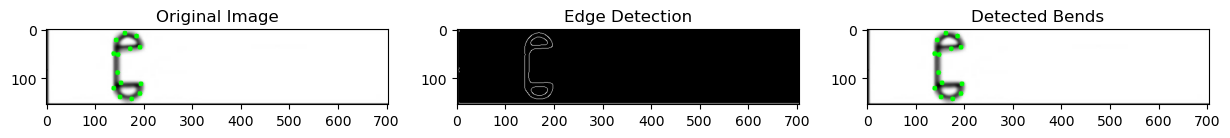

In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return None, None

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Laplacian edge detection
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    lap = np.uint8(np.absolute(lap))

    # Contour detection
    contours, _ = cv2.findContours(lap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Remove small objects by calculating the perimeter
    perimeter_threshold = 60  # Adjust this threshold as needed
    filtered_contours = [cnt for cnt in contours if cv2.arcLength(cnt, True) > perimeter_threshold]

    # Draw contours on a white background
    white_background = np.ones_like(image) * 255
    contour_image = cv2.drawContours(white_background, filtered_contours, -1, (0, 0, 0), 2)

    # Threshold
    threshold_value = 120
    _, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)

    # Remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Invert the mask to create a mask for numbers
    mask = cv2.bitwise_not(thresh)

    return image, mask

def find_arcs(image, mask):
    # Perform edge detection using Canny on the mask
    edges = cv2.Canny(mask, 80, 100)

    # Find contours in the edge map
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    def detect_bends(contour, angle_threshold=30, distance_threshold=20):
        bends = 0
        significant_points = []

        for i in range(2, len(contour) - 2):
            prev_point = contour[i - 2][0]
            current_point = contour[i][0]
            next_point = contour[i + 2][0]

            # Calculate vectors
            vector1 = np.array([current_point[0] - prev_point[0], current_point[1] - prev_point[1]])
            vector2 = np.array([next_point[0] - current_point[0], next_point[1] - current_point[1]])

            # Normalize vectors
            norm1 = np.linalg.norm(vector1)
            norm2 = np.linalg.norm(vector2)
            if norm1 == 0 or norm2 == 0:
                continue

            vector1 = vector1 / norm1
            vector2 = vector2 / norm2

            # Calculate dot product and angle
            dot_product = np.dot(vector1, vector2)
            angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

            # Check if the angle indicates a significant bend
            if angle < angle_threshold:
                significant_points.append(current_point)

        # Group significant points that are close to each other
        if significant_points:
            grouped_points = [significant_points[0]]
            for pt in significant_points[1:]:
                if np.linalg.norm(np.array(pt) - np.array(grouped_points[-1])) > distance_threshold:
                    grouped_points.append(pt)

            bends = len(grouped_points)
            for pt in grouped_points:
                cv2.circle(image, tuple(pt), 5, (0, 255, 0), -1)

        return bends

    total_bends = 0
    for contour in contours:
        total_bends += detect_bends(contour)

    # Display the result
    print(f"No. of bends = {total_bends}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title('Edge Detection')
    plt.imshow(edges, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Detected Bends')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.show()

# Example usage
original_image_path = 'circ_cab_upscaled.jpeg'
original_image, preprocessed_mask = preprocess_image(original_image_path)
if original_image is not None and preprocessed_mask is not None:
    find_arcs(original_image, preprocessed_mask)


### Centroid Approach on small images

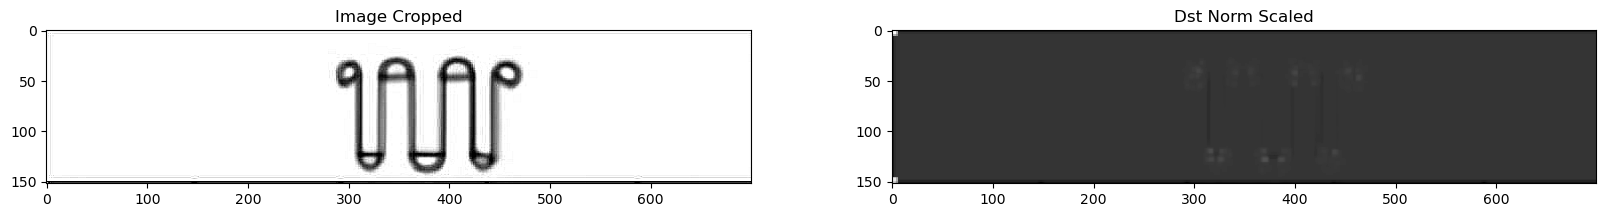

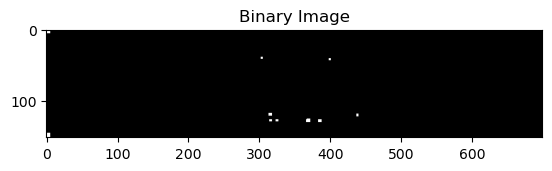

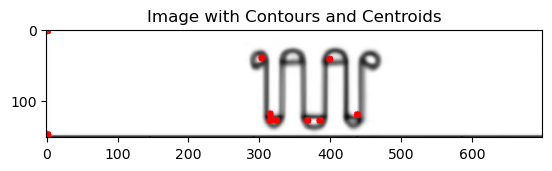

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_cropped = cv2.imread('circ_cab2_upscaled.jpeg', cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded correctly
if img_cropped is None:
    print("Error: Image not loaded. Please check the file path.")
else:
    # Apply the sharpening filter
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im = cv2.filter2D(img_cropped, -1, kernel)

    # Apply the Harris Corner Detection
    dest = cv2.cornerHarris(im, 6, 3, 0.05)

    # Dilate the corners to enhance them
    dest = cv2.dilate(dest, None)

    # Normalize the result to the range [0, 255]
    dst_norm = np.empty(dest.shape, dtype=np.float32)
    cv2.normalize(dest, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    dst_norm_scaled = cv2.convertScaleAbs(dst_norm)

    # Display the sharpened image and the normalized corner response
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].imshow(im, cmap='gray')
    axes[0].set_title('Image Cropped')
    axes[1].imshow(dst_norm_scaled, cmap='gray')
    axes[1].set_title('Dst Norm Scaled')
    plt.show()

    # Apply a binary threshold to the normalized corner response
    _, binary_image = cv2.threshold(dst_norm_scaled, 67, 255, cv2.THRESH_BINARY)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary Image')
    plt.show()

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours and centroids on a copy of the original image
    img_with_contours = cv2.cvtColor(img_cropped, cv2.COLOR_GRAY2BGR)
    centroids = []

    for contour in contours:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))

            # Draw the centroid on the image
            cv2.circle(img_with_contours, (cX, cY), 5, (255, 0, 0), -1)

    plt.imshow(img_with_contours)
    plt.title('Image with Contours and Centroids')
    plt.show()

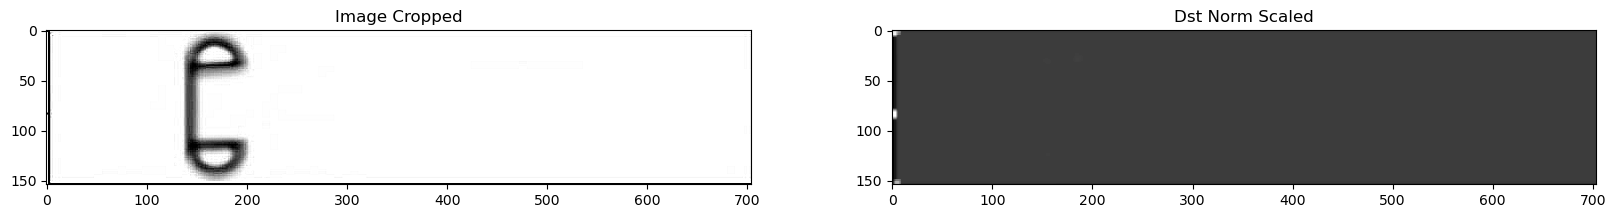

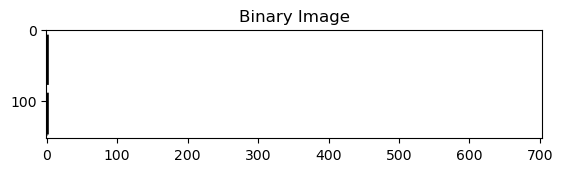

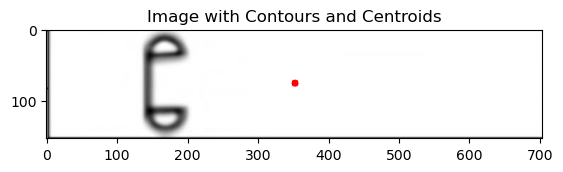

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_cropped = cv2.imread('circ_cab_upscaled.jpeg', cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded correctly
if img_cropped is None:
    print("Error: Image not loaded. Please check the file path.")
else:
    # Apply the sharpening filter
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im = cv2.filter2D(img_cropped, -1, kernel)

    # Apply the Harris Corner Detection
    dest = cv2.cornerHarris(im, 6, 3, 0.05)

    # Dilate the corners to enhance them
    dest = cv2.dilate(dest, None)

    # Normalize the result to the range [0, 255]
    dst_norm = np.empty(dest.shape, dtype=np.float32)
    cv2.normalize(dest, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    dst_norm_scaled = cv2.convertScaleAbs(dst_norm)

    # Display the sharpened image and the normalized corner response
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].imshow(im, cmap='gray')
    axes[0].set_title('Image Cropped')
    axes[1].imshow(dst_norm_scaled, cmap='gray')
    axes[1].set_title('Dst Norm Scaled')
    plt.show()

    # Apply a binary threshold to the normalized corner response
    _, binary_image = cv2.threshold(dst_norm_scaled, 30, 255, cv2.THRESH_BINARY)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary Image')
    plt.show()

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours and centroids on a copy of the original image
    img_with_contours = cv2.cvtColor(img_cropped, cv2.COLOR_GRAY2BGR)
    centroids = []

    for contour in contours:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))

            # Draw the centroid on the image
            cv2.circle(img_with_contours, (cX, cY), 5, (255, 0, 0), -1)

    plt.imshow(img_with_contours)
    plt.title('Image with Contours and Centroids')
    plt.show()

Number of bends found: 15


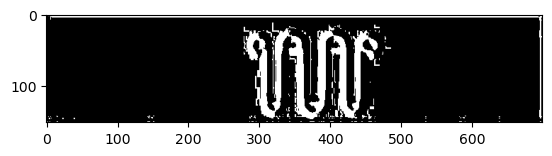

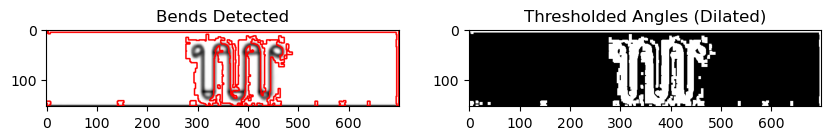

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
image_rgb = cv2.imread('cir_cab2_upscaled.jpeg')  # Load in color for visualization later
img_gray = cv2.imread('cir_cab2_upscaled.jpeg', cv2.IMREAD_GRAYSCALE)

# Thresholding (adjust the threshold value as needed)
_, binary_image = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY_INV)
plt.imshow(binary_image, cmap='gray')

# Calculate image gradient (Sobel) for edge orientation
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)

# Calculate edge angles
edges = cv2.Canny(img_gray, 100, 200)
angle = np.arctan2(dy, dx)  # Angle in radians
angle_degrees = np.degrees(angle)

# Visualize angles (optional)
plt.imshow(angle_degrees, cmap='hsv')

# Threshold angles to find bends (experiment with threshold)
angle_thresholded = (angle_degrees > 80) | (angle_degrees < -100)
plt.imshow(angle_thresholded, cmap='gray')

# Morphological operations to clean up bends
kernel = np.ones((5, 5), np.uint8)
angle_thresholded_dilated = cv2.dilate(angle_thresholded.astype(np.uint8), kernel, iterations=1)

# Find bend contours
contours, _ = cv2.findContours(angle_thresholded_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours (noise)
contours = [c for c in contours if cv2.contourArea(c) > 30]

# Draw bends on the original RGB image
for contour in contours:
    cv2.drawContours(image_rgb, [contour], -1, (255, 0, 0), 2)  # Red contours

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_rgb)
plt.title('Bends Detected')
plt.subplot(122)
plt.imshow(angle_thresholded_dilated, cmap='gray')
plt.title('Thresholded Angles (Dilated)')

print(f"Number of bends found: {len(contours)}")
plt.show()


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# reading and converting img to grayscale
image_rgb = cv2.imread('cir_cab2_upscaled.jpeg')
img = cv2.imread('cir_cab2_upscaled.jpeg', cv2.IMREAD_GRAYSCALE)

# Setting a threshold limit to convert all pixel below threshold to black and above to white
gray2 = np.zeros(img.shape)
gray2 [img < 210] = 255
gray2 [img > 130] = 0

# Edge detection using Canny
edges = cv2.Canny(img, 100, 200)

# Sobel operator for gradient calculation
dx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3, borderType=cv2.BORDER_REPLICATE)
dy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3, borderType=cv2.BORDER_REPLICATE)

# Angle calculation
angle = np.zeros_like(img, dtype=np.float64)
y, x = np.where(edges > 0)
angle[y, x] = np.arctan2(dy[y, x], dx[y, x])
angle_degrees = np.degrees(angle)

# Normalize angles to range [0, 1]
normalized_angles = (angle_degrees - angle_degrees.min()) / (angle_degrees.max() - angle_degrees.min())
# Scale to range [0, 255]
angle_visualization = (normalized_angles * 255).astype(np.uint8)

# User-defined threshold value
user_threshold_value = 120

# Binary thresholding
angle_visualization_inverted = cv2.bitwise_not(angle_visualization)
_, binary_thresholded = cv2.threshold(angle_visualization_inverted, user_threshold_value, 255, cv2.THRESH_BINARY)

# Otsu's thresholding
_, otsu_thresholded = cv2.threshold(angle_visualization_inverted, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Find contours
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(binary_thresholded, kernel, iterations=1)
contours, _ = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out contours with area less than 20
contours = [contour for contour in contours if cv2.contourArea(contour) > 20]

# Draw remaining contours on the RGB image in red
img_arr_rgb = cv2.cvtColor(binary_thresholded, cv2.COLOR_GRAY2RGB)
contour_image = img_arr_rgb.copy()
cv2.drawContours(contour_image, contours, -1, (255, 0,0), -1)

# Count number of bends
bends = len(contours)

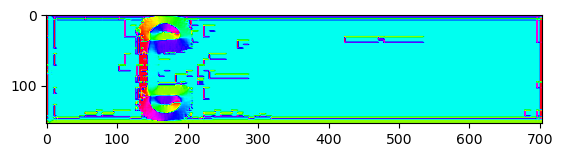

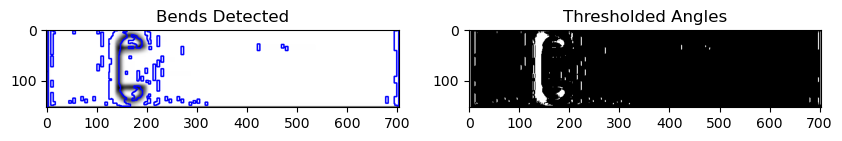

Number of bends found: 50


In [13]:
## Gemini

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
image_rgb = cv2.imread('circ_cab_upscaled.jpeg')
img_gray = cv2.imread('circ_cab_upscaled.jpeg', cv2.IMREAD_GRAYSCALE)

# Thresholding (adjust the values if needed)
_, binary_thresholded = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY_INV)

# Calculate gradients (Sobel) for edge orientation
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3, borderType=cv2.BORDER_REPLICATE)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3, borderType=cv2.BORDER_REPLICATE)

# Calculate edge angles
edges = cv2.Canny(img_gray, 100, 200)
angle = np.arctan2(dy, dx)
angle_degrees = np.degrees(angle)

# Visualize angles (optional, for debugging)
plt.imshow(angle_degrees, cmap='hsv')

# Threshold angles to find bends (adjust threshold as needed)
angle_thresholded = (angle_degrees > 120) | (angle_degrees < -120)

# Morphological dilation to connect bend segments
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(angle_thresholded.astype(np.uint8), kernel, iterations=1)

# Find bend contours
contours, _ = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours (noise)
contours = [c for c in contours if cv2.contourArea(c) > 20]

# Draw bends on the original RGB image
for contour in contours:
    cv2.drawContours(image_rgb, [contour], -1, (255, 0, 0), 2)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))  # Convert back to RGB for matplotlib
plt.title('Bends Detected')
plt.subplot(122)
plt.imshow(angle_thresholded, cmap='gray')
plt.title('Thresholded Angles')
plt.show()

print(f"Number of bends found: {len(contours)}")
